In [1]:
import json

In [2]:
with open("../sub_functions.json", 'r') as fp:
    grid_returning_map = json.load(fp)

In [3]:
import ast
import textwrap
from typing import Dict, Any, List, Tuple
import os
import importlib.util


In [4]:
def import_dsl_functions(dsl_file_path: str) -> Dict[str, Any]:
    spec = importlib.util.spec_from_file_location("dsl", dsl_file_path)
    dsl_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dsl_module)
    return {name: getattr(dsl_module, name) for name in dir(dsl_module) if not name.startswith('_')}

def execute_sub_function(sub_function_str: str, input_grid: Tuple[Tuple[int, ...], ...], dsl_functions: Dict[str, Any], constants: Dict[str, Any]) -> Tuple[Tuple[int, ...], ...]:
    # Parse the sub-function string
    sub_function_ast = ast.parse(sub_function_str).body[0].value

    def eval_node(node):
        if isinstance(node, ast.Call):
            func_name = node.func.id
            args = [eval_node(arg) for arg in node.args]
            return dsl_functions[func_name](*args)
        elif isinstance(node, ast.Name):
            if node.id == 'I':
                return input_grid
            elif node.id in constants:
                return constants[node.id]
            elif node.id in dsl_functions:
                return dsl_functions[node.id]
            else:
                raise NameError(f"Name '{node.id}' is not defined")
        elif isinstance(node, ast.Num):
            return node.n
        else:
            raise ValueError(f"Unsupported node type: {type(node)}")

    return eval_node(sub_function_ast)


In [5]:
dsl_functions = import_dsl_functions('dsl.py')

In [6]:
import sys

In [7]:
def read_file(file_path: str) -> str:
    with open(file_path, 'r') as file:
        return file.read()
def parse_constants(code: str) -> Dict[str, Any]:
    tree = ast.parse(code)
    constants = {}
    for node in ast.walk(tree):
        if isinstance(node, ast.Assign):
            for target in node.targets:
                if isinstance(target, ast.Name) and target.id.isupper():
                    if isinstance(node.value, ast.Num):
                        constants[target.id] = node.value.n
                    elif isinstance(node.value, ast.UnaryOp) and isinstance(node.value.op, ast.USub):
                        # Handle negative numbers
                        constants[target.id] = -node.value.operand.n
                    elif isinstance(node.value, ast.Tuple):
                        constants[target.id] = tuple(
                            elt.n if isinstance(elt, ast.Num) 
                            else -elt.operand.n if isinstance(elt, ast.UnaryOp) and isinstance(elt.op, ast.USub)
                            else None 
                            for elt in node.value.elts
                        )
                    elif sys.version_info >= (3, 8) and isinstance(node.value, ast.Constant):
                        # Handle booleans and other constants in Python 3.8+
                        constants[target.id] = node.value.value
                    elif sys.version_info < (3, 8) and isinstance(node.value, ast.NameConstant):
                        # Handle booleans in Python 3.7 and earlier
                        constants[target.id] = node.value.value
    return constants



In [8]:
constants_code = read_file('constants.py')
constants = parse_constants(constants_code)


In [9]:
def plot_task(
    task: List[dict],
    title: str = None
) -> None:
    """
    displays a task
    """
    cmap = ListedColormap([
        '#000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
    ])
    norm = Normalize(vmin=0, vmax=9)
    args = {'cmap': cmap, 'norm': norm}
    height = 2
    width = len(task)
    figure_size = (width * 3, height * 3)
    figure, axes = plt.subplots(height, width, figsize=figure_size)
    if width > 1:
        for column, example in enumerate(task):
            axes[0, column].imshow(example['input'], **args)
            axes[1, column].imshow(example['output'], **args)
            axes[0, column].axis('off')
            axes[1, column].axis('off')
    else:
        example=task[0]
        axes[0].imshow(example['input'], **args)
        axes[1].imshow(example['output'], **args)
        axes[0].axis('off')
        axes[1].axis('off')
    if title is not None:
        figure.suptitle(title, fontsize=20)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


In [10]:
def get_data(train=True):
    path = f'arc_original/{"training" if train else "evaluation"}'
    data = {}
    for fn in os.listdir(path):
        with open(f'{path}/{fn}') as f:
            data[fn.rstrip('.json')] = json.load(f)
    ast = lambda g: tuple(tuple(r) for r in g)
    return {
        'train': {k: [{
            'input': ast(e['input']),
            'output': ast(e['output']),
        } for e in v['train']] for k, v in data.items()},
        'test': {k: [{
            'input': ast(e['input']),
            'output': ast(e['output']),
        } for e in v['test']] for k, v in data.items()}
    }


In [11]:
data = get_data()

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize


In [13]:
import numpy as np

In [14]:
random_10 = np.random.choice(list(grid_returning_map.keys()), size=10, replace=False).tolist()

In [15]:
contained = []
for func_name in random_10:
    key = func_name.replace("solve_", '')
    for sub_func1 in grid_returning_map[func_name]:
        for sub_func2 in grid_returning_map[func_name]:
            if sub_func1 != sub_func2 and len(sub_func1) < len(sub_func2):
                if sub_func1 in sub_func2:
                    contained.append((key, sub_func1, sub_func2))
                    

In [16]:
contained[5]

('a9f96cdd',
 'fill(replace(I, TWO, ZERO), THREE, shift(ofcolor(I, TWO), NEG_UNITY))',
 'fill(fill(replace(I, TWO, ZERO), THREE, shift(ofcolor(I, TWO), NEG_UNITY)), SIX, shift(ofcolor(I, TWO), UP_RIGHT))')

In [17]:
import ast
from typing import Optional, Tuple

def parse_composition(composition: str) -> ast.Call:
    """Parse a function composition string into an AST."""
    return ast.parse(composition).body[0].value

def is_grid_input(node: ast.expr) -> bool:
    """Check if a node represents a grid input (assumed to be a single uppercase letter)."""
    return isinstance(node, ast.Name) and node.id.isupper() and len(node.id) == 1

def find_subtree_and_remainder(tree: ast.Call, subtree: ast.Call) -> Tuple[Optional[ast.Call], Optional[ast.Call]]:
    """
    Find a subtree within a larger tree and return the remainder.
    Returns a tuple of (node where subtree is found, parent of that node).
    """
    if ast.dump(tree) == ast.dump(subtree):
        return tree, None
    
    if isinstance(tree, ast.Call):
        for i, arg in enumerate(tree.args):
            result, _ = find_subtree_and_remainder(arg, subtree)
            if result:
                # Create a copy of the tree with the matched subtree replaced by a placeholder
                remainder = ast.Call(
                    func=tree.func,
                    args=tree.args[:i] + [ast.Name(id='PLACEHOLDER', ctx=ast.Load())] + tree.args[i+1:],
                    keywords=tree.keywords
                )
                return result, remainder
    
    return None, None

def contains_grid_input(node: ast.AST, original_input: str) -> bool:
    """Check if the AST contains the original grid input."""
    if isinstance(node, ast.Name) and node.id == original_input:
        return True
    return any(contains_grid_input(child, original_input) for child in ast.iter_child_nodes(node))

def is_strictly_contained(larger: str, smaller: str) -> bool:
    """
    Check if the smaller composition is strictly contained within the larger composition.
    
    Args:
    larger (str): The larger function composition.
    smaller (str): The smaller function composition.
    
    Returns:
    bool: True if smaller is strictly contained within larger, False otherwise.
    """
    larger_ast = parse_composition(larger)
    smaller_ast = parse_composition(smaller)
    
    # Check if the smaller composition is exactly the same as the larger one
    if ast.dump(larger_ast) == ast.dump(smaller_ast):
        return False
    
    # Find the subtree in the larger composition that matches the smaller composition
    subtree, remainder = find_subtree_and_remainder(larger_ast, smaller_ast)
    
    if subtree and remainder:
        # Find the original input grid name
        original_input = None
        for node in ast.walk(subtree):
            if is_grid_input(node):
                original_input = node.id
                break
        
        if original_input:
            # Check if the remainder does not contain the original input grid
            return not contains_grid_input(remainder, original_input)
    
    return False

# Test the function
test_cases = [
    ("vmirror(hmirror(I))", "hmirror(I)"),
    ("fill(canvas(ZERO, astuple(size(objects(I, T, F, T)), size(objects(I, T, F, T)))), EIGHT, shoot(ORIGIN, UNITY))",
     "canvas(ZERO, astuple(size(objects(I, T, F, T)), size(objects(I, T, F, T))))"),
    ("f(g(h(I)))", "g(h(I))"),
    ("f(g(h(I)))", "f(g(I))"),
    ("f(g(h(I)))", "f(I)"),
    ("f(g(h(I)))", "h(I)"),
    ("f(g(h(I)))", "g(I)"),
]

for larger, smaller in test_cases:
    result = is_strictly_contained(larger, smaller)
    print(f"Is '{smaller}' strictly contained in '{larger}'? {result}")

Is 'hmirror(I)' strictly contained in 'vmirror(hmirror(I))'? True
Is 'canvas(ZERO, astuple(size(objects(I, T, F, T)), size(objects(I, T, F, T))))' strictly contained in 'fill(canvas(ZERO, astuple(size(objects(I, T, F, T)), size(objects(I, T, F, T)))), EIGHT, shoot(ORIGIN, UNITY))'? True
Is 'g(h(I))' strictly contained in 'f(g(h(I)))'? True
Is 'f(g(I))' strictly contained in 'f(g(h(I)))'? False
Is 'f(I)' strictly contained in 'f(g(h(I)))'? False
Is 'h(I)' strictly contained in 'f(g(h(I)))'? True
Is 'g(I)' strictly contained in 'f(g(h(I)))'? False


In [18]:
def references_input_grid(func_def: ast.FunctionDef) -> bool:
    """
    Check if the function references the input grid 'I'.
    
    :param func_def: The AST node of the function definition
    :return: True if the function references 'I', False otherwise
    """
    class InputGridVisitor(ast.NodeVisitor):
        def __init__(self):
            self.references_i = False

        def visit_Name(self, node):
            if node.id == 'I':
                self.references_i = True
            self.generic_visit(node)

    visitor = InputGridVisitor()
    visitor.visit(func_def)
    return visitor.references_i


In [19]:
contained = []
for func_name in random_10:
    key = func_name.replace("solve_", '')
    
    for sub_func1 in grid_returning_map[func_name]:
        for sub_func2 in grid_returning_map[func_name]:
            if references_input_grid(ast.parse(sub_func1)) and references_input_grid(ast.parse(sub_func2)):
                if sub_func1 != sub_func2 and len(sub_func1) < len(sub_func2):
                    if is_strictly_contained(sub_func2, sub_func1):
                        contained.append((key, sub_func1, sub_func2))
                    

In [20]:
len(contained)

4

In [21]:
s = "vmirror(hmirror(I), hmirror(I))"
is_strictly_contained(s, "hmirror(I)")

False

In [23]:
import ast
from typing import Optional

def parse_composition(composition: str) -> ast.Call:
    """Parse a function composition string into an AST."""
    return ast.parse(composition).body[0].value

def is_grid_input(node: ast.expr) -> bool:
    """Check if a node represents a grid input (assumed to be a single uppercase letter)."""
    return isinstance(node, ast.Name) and node.id.isupper() and len(node.id) == 1

def find_and_replace_subtree(tree: ast.Call, subtree: ast.Call, replacement: str) -> Optional[ast.Call]:
    """
    Find a subtree within a larger tree and replace it with a new variable.
    Returns the modified tree if the subtree is found, None otherwise.
    """
    if ast.dump(tree) == ast.dump(subtree):
        return ast.Name(id=replacement, ctx=ast.Load())
    
    if isinstance(tree, ast.Call):
        new_args = []
        found = False
        for arg in tree.args:
            if ast.dump(arg) == ast.dump(subtree):
                new_args.append(ast.Name(id=replacement, ctx=ast.Load()))
                found = True
            elif isinstance(arg, ast.Call):
                result = find_and_replace_subtree(arg, subtree, replacement)
                if result:
                    new_args.append(result)
                    found = True
                else:
                    new_args.append(arg)
            else:
                new_args.append(arg)
        
        if found:
            return ast.Call(func=tree.func, args=new_args, keywords=tree.keywords)
    
    return None

def contains_original_input(node: ast.AST, original_input: str) -> bool:
    """Check if the AST contains the original grid input."""
    if isinstance(node, ast.Name) and node.id == original_input:
        return True
    return any(contains_original_input(child, original_input) for child in ast.iter_child_nodes(node))

def is_strictly_contained(larger: str, smaller: str) -> bool:
    """
    Check if the smaller composition is strictly contained within the larger composition.
    
    Args:
    larger (str): The larger function composition.
    smaller (str): The smaller function composition.
    
    Returns:
    bool: True if smaller is strictly contained within larger, False otherwise.
    """
    # larger_ast = parse_composition(larger)
    # smaller_ast = parse_composition(smaller)
    
    # Check if the smaller composition is exactly the same as the larger one
    # if ast.dump(larger_ast) == ast.dump(smaller_ast):
    #     return False
    if smaller == larger:
        return False
    
    # Find the original input grid name
    # original_input = None
    # for node in ast.walk(smaller_ast):
    #     if is_grid_input(node):
    #         original_input = node.id
    #         break
    smaller_ast = parse_composition(smaller)
    original_input = "I"    
    if not contains_original_input(smaller_ast, original_input):
        return False  # No grid input found in the smaller composition
    
    # Replace the smaller composition with a new variable in the larger composition
    new_input = "new_" + original_input
    # rewritten_ast = find_and_replace_subtree(larger_ast, smaller_ast, new_input)
    rewritten_fun = larger.replace(smaller, new_input)
    rewritten_ast = parse_composition(rewritten_fun)
    # if rewritten_ast:
    #     print(ast.dump(rewritten_ast), original_input)
    
    if rewritten_ast:
        # Check if the rewritten AST contains the original input
        return not contains_original_input(rewritten_ast, original_input)
    
    return False

# Test the function
test_cases = [
    ("vmirror(hmirror(I))", "hmirror(I)"),
    ("fill(canvas(ZERO, astuple(size(objects(I, T, F, T)), size(objects(I, T, F, T)))), EIGHT, shoot(ORIGIN, UNITY))",
     "canvas(ZERO, astuple(size(objects(I, T, F, T)), size(objects(I, T, F, T))))"),
    ("f(g(h(I)))", "g(h(I))"),
    ("f(g(h(I)))", "f(g(I))"),
    ("f(g(h(I)))", "f(I)"),
    ("f(g(h(I)))", "h(I)"),
    ("f(g(h(I)))", "g(I)"),
    ("vmirror(hmirror(I), hmirror(I))", "hmirror(I)"),
    ("f(g(h(I)), g(h(I)))", "g(h(I))"),
    ("f(g(h(I)), k(g(h(I))))", "g(h(I))"),
    ("f(g(h(I)), I)", "g(h(I))"),
]

for larger, smaller in test_cases:
    result = is_strictly_contained(larger, smaller)
    print(f"Is '{smaller}' strictly contained in '{larger}'? {result}")

Is 'hmirror(I)' strictly contained in 'vmirror(hmirror(I))'? True
Is 'canvas(ZERO, astuple(size(objects(I, T, F, T)), size(objects(I, T, F, T))))' strictly contained in 'fill(canvas(ZERO, astuple(size(objects(I, T, F, T)), size(objects(I, T, F, T)))), EIGHT, shoot(ORIGIN, UNITY))'? True
Is 'g(h(I))' strictly contained in 'f(g(h(I)))'? True
Is 'f(g(I))' strictly contained in 'f(g(h(I)))'? False
Is 'f(I)' strictly contained in 'f(g(h(I)))'? False
Is 'h(I)' strictly contained in 'f(g(h(I)))'? True
Is 'g(I)' strictly contained in 'f(g(h(I)))'? False
Is 'hmirror(I)' strictly contained in 'vmirror(hmirror(I), hmirror(I))'? True
Is 'g(h(I))' strictly contained in 'f(g(h(I)), g(h(I)))'? True
Is 'g(h(I))' strictly contained in 'f(g(h(I)), k(g(h(I))))'? True
Is 'g(h(I))' strictly contained in 'f(g(h(I)), I)'? False


In [24]:
new_contained = []
for func_name in random_10:
    key = func_name.replace("solve_", '')
    
    for sub_func1 in grid_returning_map[func_name]:
        for sub_func2 in grid_returning_map[func_name]:
            if references_input_grid(ast.parse(sub_func1)) and references_input_grid(ast.parse(sub_func2)):
                if sub_func1 != sub_func2 and len(sub_func1) < len(sub_func2):
                    if is_strictly_contained(sub_func2, sub_func1):
                        new_contained.append((key, sub_func1, sub_func2))


In [25]:
def get_contained_subfuncs(funcs):
    contained = []
    for sub_func1 in funcs:
        for sub_func2 in funcs:
            if references_input_grid(ast.parse(sub_func1)) and references_input_grid(ast.parse(sub_func2)):
                if sub_func1 != sub_func2 and len(sub_func1) < len(sub_func2):
                    if is_strictly_contained(sub_func2, sub_func1):
                        contained.append((sub_func1, sub_func2))
    return contained


In [26]:
new_contained

[('a740d043',
  'subgrid(merge(objects(I, T, T, T)), I)',
  'replace(subgrid(merge(objects(I, T, T, T)), I), ONE, ZERO)'),
 ('46f33fce',
  'downscale(rot180(I), TWO)',
  'rot180(downscale(rot180(I), TWO))'),
 ('46f33fce', 'rot180(I)', 'rot180(downscale(rot180(I), TWO))'),
 ('46f33fce', 'rot180(I)', 'downscale(rot180(I), TWO)')]

In [27]:
contained

[('a740d043',
  'subgrid(merge(objects(I, T, T, T)), I)',
  'replace(subgrid(merge(objects(I, T, T, T)), I), ONE, ZERO)'),
 ('46f33fce',
  'downscale(rot180(I), TWO)',
  'rot180(downscale(rot180(I), TWO))'),
 ('46f33fce', 'rot180(I)', 'rot180(downscale(rot180(I), TWO))'),
 ('46f33fce', 'rot180(I)', 'downscale(rot180(I), TWO)')]

In [28]:
for n in contained:
    if n not in new_contained:
        print(n)

In [29]:
len(contained)

4

In [30]:
len(new_contained)

4

In [31]:
from datasets import load_from_disk

/ext3/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
arc_data = load_from_disk("../arc_v3")

In [33]:
arc_keys = arc_data['train']['key'] + arc_data['test']['key']
arc_functions = arc_data['train']['functions'] + arc_data['test']['functions']

final_solns = {k:v for (k,v) in zip(arc_keys, arc_functions)}

In [34]:
final_solns

{'67a3c6ac': 'def solve_67a3c6ac(I):\n    return vmirror(I)\n\n\n',
 '68b16354': 'def solve_68b16354(I):\n    return hmirror(I)\n\n\n',
 '74dd1130': 'def solve_74dd1130(I):\n    return dmirror(I)\n\n\n',
 '3c9b0459': 'def solve_3c9b0459(I):\n    return rot180(I)\n\n\n',
 '6150a2bd': 'def solve_6150a2bd(I):\n    return rot180(I)\n\n\n',
 '9172f3a0': 'def solve_9172f3a0(I):\n    return upscale(I, THREE)\n\n\n',
 '9dfd6313': 'def solve_9dfd6313(I):\n    return dmirror(I)\n\n\n',
 'a416b8f3': 'def solve_a416b8f3(I):\n    return hconcat(I, I)\n\n\n',
 'b1948b0a': 'def solve_b1948b0a(I):\n    return replace(I, SIX, TWO)\n\n\n',
 'c59eb873': 'def solve_c59eb873(I):\n    return upscale(I, TWO)\n\n\n',
 'c8f0f002': 'def solve_c8f0f002(I):\n    return replace(I, SEVEN, FIVE)\n\n\n',
 'd10ecb37': 'def solve_d10ecb37(I):\n    return crop(I, ORIGIN, TWO_BY_TWO)\n\n\n',
 'd511f180': 'def solve_d511f180(I):\n    return switch(I, FIVE, EIGHT)\n\n\n',
 'ed36ccf7': 'def solve_ed36ccf7(I):\n    return ro

In [35]:
import re
def get_impls(text):
    pattern = r"return\s+((?:.|\n)*?)(?=\n\s*\n|$)"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(1)

In [36]:

for k in final_solns:
    final_solns[k] = get_impls(final_solns[k])

In [37]:
final_solns

{'67a3c6ac': 'vmirror(I)',
 '68b16354': 'hmirror(I)',
 '74dd1130': 'dmirror(I)',
 '3c9b0459': 'rot180(I)',
 '6150a2bd': 'rot180(I)',
 '9172f3a0': 'upscale(I, THREE)',
 '9dfd6313': 'dmirror(I)',
 'a416b8f3': 'hconcat(I, I)',
 'b1948b0a': 'replace(I, SIX, TWO)',
 'c59eb873': 'upscale(I, TWO)',
 'c8f0f002': 'replace(I, SEVEN, FIVE)',
 'd10ecb37': 'crop(I, ORIGIN, TWO_BY_TWO)',
 'd511f180': 'switch(I, FIVE, EIGHT)',
 'ed36ccf7': 'rot270(I)',
 '4c4377d9': 'vconcat(hmirror(I), I)',
 '6d0aefbc': 'hconcat(I, vmirror(I))',
 '6fa7a44f': 'vconcat(I, hmirror(I))',
 '5614dbcf': 'downscale(replace(I, FIVE, ZERO), THREE)',
 '5bd6f4ac': 'crop(I, tojvec(SIX), THREE_BY_THREE)',
 '5582e5ca': 'canvas(mostcolor(I), THREE_BY_THREE)',
 '8be77c9e': 'vconcat(I, hmirror(I))',
 'c9e6f938': 'hconcat(I, vmirror(I))',
 '2dee498d': 'first(hsplit(I, THREE))',
 '1cf80156': 'subgrid(first(objects(I, T, T, T)), I)',
 '32597951': 'fill(I, THREE, delta(ofcolor(I, EIGHT)))',
 '25ff71a9': 'move(I, first(objects(I, T, T, T))

In [111]:
from tqdm import tqdm
ct = 0
incremental_examples = {}
incremental_examples['train'] = {}
incremental_examples['test'] = {}
solution_programs = {}

for func_name in tqdm(grid_returning_map):
    key = func_name.replace("solve_", '')
    orig_examples = data['train'][key]
    test_examples = data['test'][key]
    # plot_task(orig_examples, key + "_ORIGINAL")
    # original_soln = final_solns[key]
    contained_sub_funcs = get_contained_subfuncs(grid_returning_map[func_name])
    curr_idx = 0
    if contained_sub_funcs != []:
        
        for (smaller, larger) in contained_sub_funcs:
            new_func_key = f"{key}_incr_input_{curr_idx}"
            print("Larger subfunc", larger)
            print("Smaller subfunc", smaller)
            modified_examples = []
            # both_modified = []
            # rewrites = []
            rewrite_larger_func = larger.replace(smaller, "I")
            related_func_keys = [k for k in solution_programs if key in k]
            related_funcs = [solution_programs[k] for k in related_func_keys]
            if rewrite_larger_func not in related_funcs:
                print("rewrite", rewrite_larger_func)
                for ex in orig_examples:
                    input_grid = ex['input']
                    output = execute_sub_function(larger, input_grid, dsl_functions, constants)
                    new_input = execute_sub_function(smaller, input_grid, dsl_functions, constants)
                    modified_examples.append({"input":new_input,"output":output})
                    
                    new_output = execute_sub_function(rewrite_larger_func, new_input, dsl_functions, constants)
                    # both_modified.append({"input":new_input,"output":new_output})
                    # rewrites.append(rewrite_larger_func)
                    assert new_output == output
                
                modified_tests = []
                for test_ex in test_examples:
                    test_input = test_ex['input']
                    modified_output = execute_sub_function(larger, test_input, dsl_functions, constants)
                    new_input = execute_sub_function(smaller, test_input, dsl_functions, constants)
                    modified_tests.append({'input': new_input, 'output':modified_output})
                    new_output = execute_sub_function(rewrite_larger_func, new_input, dsl_functions, constants)
                    assert new_output == modified_output
    
                
                if len(modified_examples) > 0 and len(modified_tests) > 0:
                    # plot_task(modified_examples, key + "_MODIFIED")
                    # ct += 1
                    incremental_examples['train'][new_func_key] = modified_examples
                    incremental_examples['test'][new_func_key] = modified_tests
                    solution_programs[new_func_key] = rewrite_larger_func
                    curr_idx += 1

    # else:
    #     print("functions:")
    #     for f in grid_returning_map[func_name]:
    #         print(f)
    #         print("")
        # print("orig")
        # print(original_soln)


 24%|██▎       | 90/381 [00:00<00:00, 893.52it/s]

Larger subfunc downscale(replace(I, FIVE, ZERO), THREE)
Smaller subfunc replace(I, FIVE, ZERO)
rewrite downscale(I, THREE)
Larger subfunc vconcat(hmirror(bottomhalf(I)), bottomhalf(I))
Smaller subfunc bottomhalf(I)
rewrite vconcat(hmirror(I), I)
Larger subfunc vconcat(hmirror(bottomhalf(I)), bottomhalf(I))
Smaller subfunc bottomhalf(I)
Larger subfunc hconcat(subgrid(first(objects(I, T, T, T)), I), subgrid(first(objects(I, T, T, T)), I))
Smaller subfunc subgrid(first(objects(I, T, T, T)), I)
rewrite hconcat(I, I)
Larger subfunc hconcat(subgrid(first(objects(I, T, T, T)), I), subgrid(first(objects(I, T, T, T)), I))
Smaller subfunc subgrid(first(objects(I, T, T, T)), I)
Larger subfunc vconcat(hconcat(I, vmirror(I)), hmirror(hconcat(I, vmirror(I))))
Smaller subfunc hconcat(I, vmirror(I))
rewrite vconcat(I, hmirror(I))
Larger subfunc vconcat(hconcat(I, vmirror(I)), hmirror(hconcat(I, vmirror(I))))
Smaller subfunc hconcat(I, vmirror(I))
Larger subfunc vconcat(hconcat(I, vmirror(I)), hmirror(

 47%|████▋     | 180/381 [00:00<00:00, 490.78it/s]

Larger subfunc cellwise(upscale(subgrid(merge(objects(I, T, F, T)), I), THREE), vconcat(vconcat(hconcat(hconcat(subgrid(merge(objects(I, T, F, T)), I), subgrid(merge(objects(I, T, F, T)), I)), subgrid(merge(objects(I, T, F, T)), I)), hconcat(hconcat(subgrid(merge(objects(I, T, F, T)), I), subgrid(merge(objects(I, T, F, T)), I)), subgrid(merge(objects(I, T, F, T)), I))), hconcat(hconcat(subgrid(merge(objects(I, T, F, T)), I), subgrid(merge(objects(I, T, F, T)), I)), subgrid(merge(objects(I, T, F, T)), I))), ZERO)
Smaller subfunc subgrid(merge(objects(I, T, F, T)), I)
rewrite cellwise(upscale(I, THREE), vconcat(vconcat(hconcat(hconcat(I, I), I), hconcat(hconcat(I, I), I)), hconcat(hconcat(I, I), I)), ZERO)
Larger subfunc vconcat(vconcat(hconcat(hconcat(subgrid(merge(objects(I, T, F, T)), I), subgrid(merge(objects(I, T, F, T)), I)), subgrid(merge(objects(I, T, F, T)), I)), hconcat(hconcat(subgrid(merge(objects(I, T, F, T)), I), subgrid(merge(objects(I, T, F, T)), I)), subgrid(merge(object

 63%|██████▎   | 239/381 [00:00<00:00, 242.29it/s]

Larger subfunc fill(underfill(I, NEG_ONE, mfilter(prapply(connect, ofcolor(I, FOUR), ofcolor(I, FOUR)), fork(either, vline, hline))), TWO, mapply(compose(backdrop, inbox), objects(underfill(I, NEG_ONE, mfilter(prapply(connect, ofcolor(I, FOUR), ofcolor(I, FOUR)), fork(either, vline, hline))), F, F, T)))
Smaller subfunc underfill(I, NEG_ONE, mfilter(prapply(connect, ofcolor(I, FOUR), ofcolor(I, FOUR)), fork(either, vline, hline)))
rewrite fill(I, TWO, mapply(compose(backdrop, inbox), objects(I, F, F, T)))
Larger subfunc replace(fill(underfill(I, NEG_ONE, mfilter(prapply(connect, ofcolor(I, FOUR), ofcolor(I, FOUR)), fork(either, vline, hline))), TWO, mapply(compose(backdrop, inbox), objects(underfill(I, NEG_ONE, mfilter(prapply(connect, ofcolor(I, FOUR), ofcolor(I, FOUR)), fork(either, vline, hline))), F, F, T))), NEG_ONE, ZERO)
Smaller subfunc underfill(I, NEG_ONE, mfilter(prapply(connect, ofcolor(I, FOUR), ofcolor(I, FOUR)), fork(either, vline, hline)))
Larger subfunc fill(underfill(I,

 73%|███████▎  | 277/381 [00:01<00:00, 201.63it/s]

Larger subfunc fill(subgrid(ofcolor(I, ONE), fill(I, TWO, box(ofcolor(I, ONE)))), TWO, branch(greater(size(mapply(vfrontier, ofcolor(subgrid(ofcolor(I, ONE), fill(I, TWO, box(ofcolor(I, ONE)))), ONE))), size(mapply(hfrontier, ofcolor(subgrid(ofcolor(I, ONE), fill(I, TWO, box(ofcolor(I, ONE)))), ONE)))), mapply(hfrontier, ofcolor(subgrid(ofcolor(I, ONE), fill(I, TWO, box(ofcolor(I, ONE)))), ONE)), mapply(vfrontier, ofcolor(subgrid(ofcolor(I, ONE), fill(I, TWO, box(ofcolor(I, ONE)))), ONE))))
Smaller subfunc subgrid(ofcolor(I, ONE), fill(I, TWO, box(ofcolor(I, ONE))))
rewrite fill(I, TWO, branch(greater(size(mapply(vfrontier, ofcolor(I, ONE))), size(mapply(hfrontier, ofcolor(I, ONE)))), mapply(hfrontier, ofcolor(I, ONE)), mapply(vfrontier, ofcolor(I, ONE))))
Larger subfunc fill(subgrid(ofcolor(I, ONE), fill(I, TWO, box(ofcolor(I, ONE)))), TWO, branch(greater(size(mapply(vfrontier, ofcolor(subgrid(ofcolor(I, ONE), fill(I, TWO, box(ofcolor(I, ONE)))), ONE))), size(mapply(hfrontier, ofcolor

 80%|████████  | 306/381 [00:01<00:00, 114.43it/s]

Larger subfunc fill(rot270(merge(sfilter(vsplit(rot90(merge(sfilter(vsplit(subgrid(argmax(objects(I, T, F, F), size), I), height(subgrid(argmax(objects(I, T, F, F), size), I))), compose(lbind(greater, FOUR), numcolors)))), width(subgrid(argmax(objects(I, T, F, F), size), I))), compose(lbind(greater, FOUR), numcolors)))), leastcolor(rot270(merge(sfilter(vsplit(rot90(merge(sfilter(vsplit(subgrid(argmax(objects(I, T, F, F), size), I), height(subgrid(argmax(objects(I, T, F, F), size), I))), compose(lbind(greater, FOUR), numcolors)))), width(subgrid(argmax(objects(I, T, F, F), size), I))), compose(lbind(greater, FOUR), numcolors))))), mapply(fork(combine, vfrontier, hfrontier), ofcolor(rot270(merge(sfilter(vsplit(rot90(merge(sfilter(vsplit(subgrid(argmax(objects(I, T, F, F), size), I), height(subgrid(argmax(objects(I, T, F, F), size), I))), compose(lbind(greater, FOUR), numcolors)))), width(subgrid(argmax(objects(I, T, F, F), size), I))), compose(lbind(greater, FOUR), numcolors)))), leastco

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

 86%|████████▌ | 326/381 [00:12<00:05, 10.09it/s] 

Larger subfunc replace(hmirror(crop(merge(repeat(crop(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), ulcorner(ofcolor(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), ONE)), astuple(decrement(height(subgrid(ofcolor(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), ONE), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))))), width(subgrid(ofcolor(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), ONE), fill(fill(I, ONE, shoot(first

 91%|█████████▏| 348/381 [00:12<00:02, 12.67it/s]

Larger subfunc fill(subgrid(first(objects(I, F, F, T)), I), ZERO, shift(asindices(apply_func(power(trim, TWO), subgrid(first(objects(I, F, F, T)), I))), TWO_BY_TWO))
Smaller subfunc subgrid(first(objects(I, F, F, T)), I)
rewrite fill(I, ZERO, shift(asindices(apply_func(power(trim, TWO), I)), TWO_BY_TWO))
Larger subfunc fill(subgrid(first(objects(I, F, F, T)), I), ZERO, shift(asindices(apply_func(power(trim, TWO), subgrid(first(objects(I, F, F, T)), I))), TWO_BY_TWO))
Smaller subfunc subgrid(first(objects(I, F, F, T)), I)
Larger subfunc fill(subgrid(first(objects(I, F, F, T)), I), ZERO, shift(asindices(apply_func(power(trim, TWO), subgrid(first(objects(I, F, F, T)), I))), TWO_BY_TWO))
Smaller subfunc subgrid(first(objects(I, F, F, T)), I)
Larger subfunc fill(subgrid(first(objects(I, F, F, T)), I), ZERO, shift(asindices(apply_func(power(trim, TWO), subgrid(first(objects(I, F, F, T)), I))), TWO_BY_TWO))
Smaller subfunc subgrid(first(objects(I, F, F, T)), I)
Larger subfunc fill(subgrid(fir

 91%|█████████▏| 348/381 [00:24<00:02, 12.67it/s]

Larger subfunc fill(fill(fill(fill(fill(fill(I, EIGHT, mapply(lbind(shift, asobject(canvas(FIVE, TWO_BY_TWO))), occurrences(I, asobject(canvas(FIVE, TWO_BY_TWO))))), TWO, mapply(lbind(shift, asobject(vconcat(canvas(EIGHT, astuple(TWO, ONE)), canvas(FIVE, UNITY)))), occurrences(fill(I, EIGHT, mapply(lbind(shift, asobject(canvas(FIVE, TWO_BY_TWO))), occurrences(I, asobject(canvas(FIVE, TWO_BY_TWO))))), asobject(vconcat(canvas(EIGHT, astuple(TWO, ONE)), canvas(FIVE, UNITY)))))), TWO, mapply(lbind(shift, asobject(canvas(FIVE, astuple(ONE, THREE)))), occurrences(fill(fill(I, EIGHT, mapply(lbind(shift, asobject(canvas(FIVE, TWO_BY_TWO))), occurrences(I, asobject(canvas(FIVE, TWO_BY_TWO))))), TWO, mapply(lbind(shift, asobject(vconcat(canvas(EIGHT, astuple(TWO, ONE)), canvas(FIVE, UNITY)))), occurrences(fill(I, EIGHT, mapply(lbind(shift, asobject(canvas(FIVE, TWO_BY_TWO))), occurrences(I, asobject(canvas(FIVE, TWO_BY_TWO))))), asobject(vconcat(canvas(EIGHT, astuple(TWO, ONE)), canvas(FIVE, UNI

 96%|█████████▌| 366/381 [00:28<00:03,  4.10it/s]

Larger subfunc fill(fill(fill(fill(fill(I, EIGHT, mapply(lbind(shift, asobject(canvas(FIVE, TWO_BY_TWO))), occurrences(I, asobject(canvas(FIVE, TWO_BY_TWO))))), TWO, mapply(lbind(shift, asobject(vconcat(canvas(EIGHT, astuple(TWO, ONE)), canvas(FIVE, UNITY)))), occurrences(fill(I, EIGHT, mapply(lbind(shift, asobject(canvas(FIVE, TWO_BY_TWO))), occurrences(I, asobject(canvas(FIVE, TWO_BY_TWO))))), asobject(vconcat(canvas(EIGHT, astuple(TWO, ONE)), canvas(FIVE, UNITY)))))), TWO, mapply(lbind(shift, asobject(canvas(FIVE, astuple(ONE, THREE)))), occurrences(fill(fill(I, EIGHT, mapply(lbind(shift, asobject(canvas(FIVE, TWO_BY_TWO))), occurrences(I, asobject(canvas(FIVE, TWO_BY_TWO))))), TWO, mapply(lbind(shift, asobject(vconcat(canvas(EIGHT, astuple(TWO, ONE)), canvas(FIVE, UNITY)))), occurrences(fill(I, EIGHT, mapply(lbind(shift, asobject(canvas(FIVE, TWO_BY_TWO))), occurrences(I, asobject(canvas(FIVE, TWO_BY_TWO))))), asobject(vconcat(canvas(EIGHT, astuple(TWO, ONE)), canvas(FIVE, UNITY)))

 96%|█████████▋| 367/381 [00:33<00:04,  3.22it/s]

Larger subfunc rot90(paint(cover(apply(lbind(apply, maximum), papply(pair, argmax(insert(rot270(I), insert(rot180(I), insert(rot90(I), initset(I)))), chain(numcolors, lefthalf, tophalf)), vmirror(argmax(insert(rot270(I), insert(rot180(I), insert(rot90(I), initset(I)))), chain(numcolors, lefthalf, tophalf))))), combine(apply(llcorner, sizefilter(partition(apply(lbind(apply, maximum), papply(pair, argmax(insert(rot270(I), insert(rot180(I), insert(rot90(I), initset(I)))), chain(numcolors, lefthalf, tophalf)), vmirror(argmax(insert(rot270(I), insert(rot180(I), insert(rot90(I), initset(I)))), chain(numcolors, lefthalf, tophalf)))))), FOUR)), apply(lrcorner, sizefilter(partition(apply(lbind(apply, maximum), papply(pair, argmax(insert(rot270(I), insert(rot180(I), insert(rot90(I), initset(I)))), chain(numcolors, lefthalf, tophalf)), vmirror(argmax(insert(rot270(I), insert(rot180(I), insert(rot90(I), initset(I)))), chain(numcolors, lefthalf, tophalf)))))), FOUR)))), mapply(fork(recolor, color, 

 96%|█████████▋| 367/381 [00:44<00:04,  3.22it/s]

Larger subfunc fill(fill(I, THREE, sfilter(asindices(I), matcher(chain(rbind(colorcount, THREE), rbind(toobject, fill(fill(fill(I, THREE, apply_func(fork(mapply, chain(lbind(lbind, shift), compose(asobject, lbind(canvas, ZERO)), fork(argmax, compose(fork(product, identity, identity), first), compose(chain(lbind(rbind(fork, fork(multiply, first, last)), multiply), rbind(lbind(chain, compose(positive, size)), compose(asobject, lbind(canvas, ZERO))), lbind(lbind, occurrences)), last))), fork(occurrences, last, compose(compose(asobject, lbind(canvas, ZERO)), fork(argmax, compose(fork(product, identity, identity), first), compose(chain(lbind(rbind(fork, fork(multiply, first, last)), multiply), rbind(lbind(chain, compose(positive, size)), compose(asobject, lbind(canvas, ZERO))), lbind(lbind, occurrences)), last))))), astuple(interval(THREE, multiply(TWO, SIX), ONE), I))), THREE, apply_func(fork(mapply, chain(lbind(lbind, shift), compose(asobject, lbind(canvas, ZERO)), fork(argmax, compose(fo

 99%|█████████▉| 379/381 [02:56<00:05,  2.70s/it]

Larger subfunc fill(fill(I, THREE, apply_func(fork(mapply, chain(lbind(lbind, shift), compose(asobject, lbind(canvas, ZERO)), fork(argmax, compose(fork(product, identity, identity), first), compose(chain(lbind(rbind(fork, fork(multiply, first, last)), multiply), rbind(lbind(chain, compose(positive, size)), compose(asobject, lbind(canvas, ZERO))), lbind(lbind, occurrences)), last))), fork(occurrences, last, compose(compose(asobject, lbind(canvas, ZERO)), fork(argmax, compose(fork(product, identity, identity), first), compose(chain(lbind(rbind(fork, fork(multiply, first, last)), multiply), rbind(lbind(chain, compose(positive, size)), compose(asobject, lbind(canvas, ZERO))), lbind(lbind, occurrences)), last))))), astuple(interval(THREE, multiply(TWO, SIX), ONE), I))), THREE, apply_func(fork(mapply, chain(lbind(lbind, shift), compose(asobject, lbind(canvas, ZERO)), fork(argmax, compose(fork(product, identity, identity), first), compose(chain(lbind(rbind(fork, fork(multiply, first, last)), 

100%|██████████| 381/381 [02:56<00:00,  2.16it/s]

Larger subfunc switch(subgrid(argmax(objects(I, F, T, T), size), I), TWO, ZERO)
Smaller subfunc subgrid(argmax(objects(I, F, T, T), size), I)
rewrite switch(I, TWO, ZERO)
Larger subfunc switch(subgrid(argmax(objects(I, F, T, T), size), I), TWO, ZERO)
Smaller subfunc subgrid(argmax(objects(I, F, T, T), size), I)
Larger subfunc switch(subgrid(argmax(objects(I, F, T, T), size), I), TWO, ZERO)
Smaller subfunc subgrid(argmax(objects(I, F, T, T), size), I)
Larger subfunc switch(subgrid(argmax(objects(I, F, T, T), size), I), TWO, ZERO)
Smaller subfunc subgrid(argmax(objects(I, F, T, T), size), I)
Larger subfunc switch(subgrid(argmax(objects(I, F, T, T), size), I), TWO, ZERO)
Smaller subfunc subgrid(argmax(objects(I, F, T, T), size), I)
Larger subfunc switch(subgrid(argmax(objects(I, F, T, T), size), I), TWO, ZERO)
Smaller subfunc subgrid(argmax(objects(I, F, T, T), size), I)
Larger subfunc switch(subgrid(argmax(objects(I, F, T, T), size), I), TWO, ZERO)
Smaller subfunc subgrid(argmax(objects(

In [112]:
len(incremental_examples['train'])

220

In [113]:
with open("incremental_input_grid_arc_examples.json", 'w') as fp:
    json.dump(incremental_examples, fp)

with open("incremental_input_grid_arc_solutions.json", 'w') as fp:
    json.dump(solution_programs, fp)

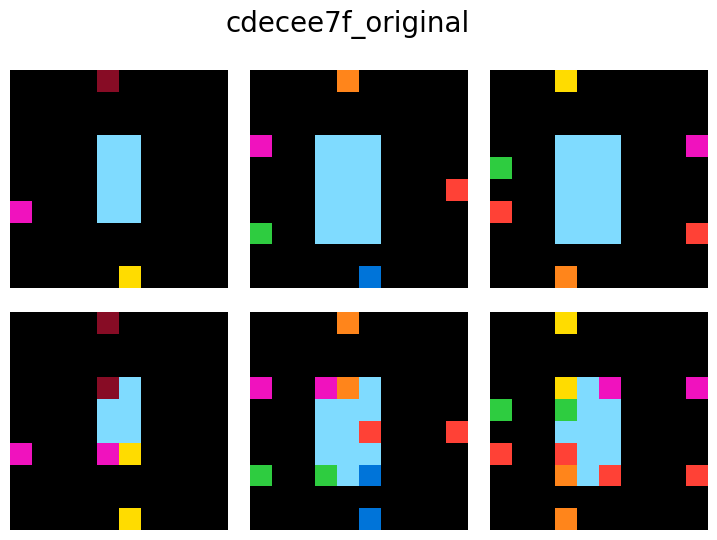

In [171]:
plot_task(data['train']['1f642eb9'], 'cdecee7f_original')

In [114]:
incremental_examples['train'].keys()

dict_keys(['5614dbcf_incr_input_0', 'f25ffba3_incr_input_0', '28bf18c6_incr_input_0', '3af2c5a8_incr_input_0', '62c24649_incr_input_0', '67e8384a_incr_input_0', '46f33fce_incr_input_0', '46f33fce_incr_input_1', '46f33fce_incr_input_2', 'a740d043_incr_input_0', 'a79310a0_incr_input_0', '1e0a9b12_incr_input_0', '0d3d703e_incr_input_0', '0d3d703e_incr_input_1', '0d3d703e_incr_input_2', '0d3d703e_incr_input_3', '0d3d703e_incr_input_4', '0d3d703e_incr_input_5', '1c786137_incr_input_0', '2013d3e2_incr_input_0', '2013d3e2_incr_input_1', '2013d3e2_incr_input_2', 'f76d97a5_incr_input_0', 'ce9e57f2_incr_input_0', '0520fde7_incr_input_0', '8d5021e8_incr_input_0', '8d5021e8_incr_input_1', '928ad970_incr_input_0', 'b94a9452_incr_input_0', 'd0f5fe59_incr_input_0', 'e9afcf9a_incr_input_0', 'e9afcf9a_incr_input_1', 'e9afcf9a_incr_input_2', 'e9afcf9a_incr_input_3', 'e9afcf9a_incr_input_4', '3906de3d_incr_input_0', '3906de3d_incr_input_1', '3906de3d_incr_input_2', '7b6016b9_incr_input_0', '10fcaaa3_incr

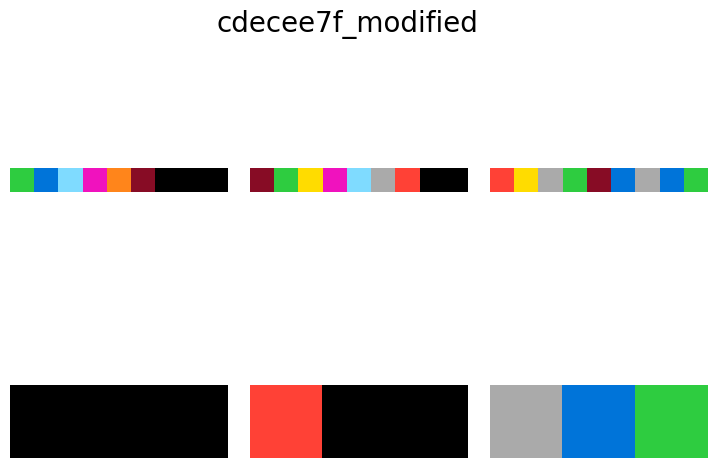

In [168]:
plot_task(incremental_examples['train']['cdecee7f_incr_input_4'], 'cdecee7f_modified')

In [157]:
solution_programs['36fdfd69_incr_input_0']

'downscale(I, TWO)'

In [170]:
list(data['train'].keys())[-1]

'1f642eb9'

In [92]:
from collections import Counter
len(Counter(solution_programs.values()))

161

In [53]:
# incremental_examples['train']['80af3007_incr_input_0']

[{'input': ((5,
    5,
    5,
    0,
    0,
    0,
    5,
    5,
    5,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    5,
    5,
    5,
    0,
    0,
    0,
    5,
    5,
    5),
   (5,
    5,
    5,
    0,
    0,
    0,
    5,
    5,
    5,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    5,
    5,
    5,
    0,
    0,
    0,
    5,
    5,
    5),
   (5,
    5,
    5,
    0,
    0,
    0,
    5,
    5,
    5,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    5,
    5,
    5,
    0,
    0,
    0,
    5,
    5,
    5),
   (0,
    0,
    0,
    5,
    5,
    5,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    5,
    5,
    5,
    0,
    0,
    0),
   (0,
    0,
    0,
    5,
    5,
    5,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    5,
    5,
    5,
    0,
    0,
    0),
   (0,
    0,
    0,
    5,
    5,
    5,

In [43]:
larger

'crop(hmirror(vconcat(vconcat(vconcat(crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)), crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(f

In [45]:
rewrite_larger_func

'crop(hmirror(I), ORIGIN, shape(I))'

In [44]:
smaller

'vconcat(vconcat(vconcat(crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)), crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, s

In [39]:
new_output

((1, 0),
 (0, 1),
 (1, 0),
 (0, 1),
 (1, 0),
 (0, 1),
 (1, 0),
 (0, 1),
 (1, 0),
 (0, 1),
 (1, 0),
 (0, 1),
 (1, 0),
 (0, 1),
 (1, 0),
 (0, 1))

In [40]:
output

((1, 0),
 (0, 1),
 (1, 0),
 (0, 1),
 (1, 0),
 (0, 1),
 (1, 0),
 (0, 1),
 (1, 0),
 (0, 1))

In [41]:
len(incremental_examples['train'])

659

In [50]:
is_strictly_contained(larger, smaller)

Call(func=Name(id='f', ctx=Load()), args=[Name(id='new_I', ctx=Load()), Name(id='I', ctx=Load())], keywords=[])


False

In [60]:
larger = 'crop(hmirror(vconcat(vconcat(vconcat(crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)), crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN))), vconcat(crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)), crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)))), vconcat(vconcat(crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)), crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN))), vconcat(crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)), crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)))))), ORIGIN, shape(I))'

In [61]:
smaller = 'vconcat(vconcat(vconcat(crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)), crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN))), vconcat(crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)), crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)))), vconcat(vconcat(crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)), crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN))), vconcat(crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)), crop(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY))), DOWN, subtract(shape(subgrid(first(objects(fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)), T, T, T)), fill(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE, shoot(urcorner(ofcolor(fill(I, ONE, shoot(first(ofcolor(I, ONE)), UP_RIGHT)), ONE)), NEG_UNITY)))), DOWN)))))'

In [62]:
is_strictly_contained(larger, smaller)

Call(func=Name(id='crop', ctx=Load()), args=[Call(func=Name(id='hmirror', ctx=Load()), args=[Name(id='new_I', ctx=Load())], keywords=[]), Name(id='ORIGIN', ctx=Load()), Call(func=Name(id='shape', ctx=Load()), args=[Name(id='I', ctx=Load())], keywords=[])], keywords=[]) I


False